In [1]:
import pandas as pd
import scipy.io
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import welch
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from scipy.signal import decimate
from skimage.transform import resize
import pywt
from scipy.io import loadmat
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.utils.data import TensorDataset, DataLoader


# Creating the Like DF

In [2]:
path = "../data/behavioralRatings.mat"
with h5py.File(path, "r") as f:
    print("HDF5 keys:", list(f.keys()))

HDF5 keys: ['behavioralRatings']


In [3]:
with h5py.File(path, "r") as f:
    br = f["behavioralRatings"]
    print("Type:", type(br))
    print("Shape:", br.shape)
    print("Dtype:", br.dtype)

Type: <class 'h5py._hl.dataset.Dataset'>
Shape: (2, 10, 20)
Dtype: float64


In [4]:
with h5py.File(path, "r") as f:
    br = f["behavioralRatings"][:]   # turn into NumPy array, shape (2, 10, 20)

In [5]:
# (2, 10, 20) to (20, 10, 2) in order to turn into same structure as matlab 
ratings = np.transpose(br, (2, 1, 0))

print(ratings.shape)

(20, 10, 2)


In [6]:
enjoyment = ratings[:, :, 1] 

In [7]:
participants = np.arange(1, 21)
songs = np.arange(1, 11)

like_df = pd.DataFrame(enjoyment,
                      index=participants,
                      columns=[f"song_{s}" for s in songs]).rename_axis("subject").reset_index()

like_df

,subject,song_1,song_2,song_3,song_4,song_5,song_6,song_7,song_8,song_9,song_10
0,1,8.0,8.0,5.0,5.0,9.0,7.0,6.0,7.0,5.0,5.0
1,2,8.0,8.0,7.0,5.0,3.0,7.0,5.0,5.0,4.0,4.0
2,3,8.0,7.0,8.0,6.0,8.0,7.0,7.0,8.0,7.0,6.0
3,4,8.0,7.0,2.0,7.0,9.0,6.0,7.0,7.0,5.0,7.0
4,5,6.0,8.0,6.0,5.0,7.0,7.0,8.0,7.0,7.0,3.0
5,6,4.0,5.0,4.0,5.0,5.0,5.0,4.0,4.0,5.0,1.0
6,7,6.0,2.0,2.0,5.0,3.0,7.0,3.0,5.0,3.0,2.0
7,8,5.0,8.0,3.0,7.0,5.0,6.0,6.0,6.0,7.0,4.0
8,9,7.0,5.0,6.0,5.0,6.0,5.0,4.0,6.0,3.0,2.0
9,10,5.0,4.0,2.0,7.0,5.0,6.0,4.0,7.0,3.0,1.0


# Feature Creation

In [8]:
# Basically mapping freq to names/categories
BANDS = {
    "delta": (1, 4),
    "theta": (4, 8),
    "alpha": (8, 12),
    "beta": (12, 30),
    "gamma_low": (30, 45),
}

In [9]:
def calculate_bandpower(f, psd, fmin, fmax):
    idx = (f >= fmin) & (f <= fmax)
    return np.trapezoid(psd[idx], f[idx])

# Loading in Cleaned EEG data

In [10]:
np.random.seed(42)

In [11]:
all_X = []
all_y = []
participant_ids = []
song_ids = []

# they had weird mappings in the study, these numbers correspond to file names
# looping through each song
for song in range(21, 31):
    # loads in the file
    load_mat_file = loadmat(f"../data/cleaned_eeg/song{song}_Imputed.mat")
    # gets the current song
    data = load_mat_file[f"data{song}"]

    fs = float(load_mat_file["fs"].squeeze())

    channels, time, participants = data.shape

    # converting werid mappings to start at 1
    song_idx = song - 20
    song_label = like_df[f"song_{song_idx}"].to_numpy()

    # loop through each participant
    for participant in range(participants):
        # get eeg data for given participant for the given song
        eeg_participant = data[:, :, participant]

        # this chunk just gets the band power for each participant for given song
        feature_list = []
        for channel in range(channels):
            f, psd = welch(eeg_participant[channel, :], fs = fs, nperseg = 2 * int(fs))
            for fmin, fmax in BANDS.values():
                band_power = calculate_bandpower(f, psd, fmin, fmax)
                feature_list.append(band_power)

        feature_vec = np.log10(np.array(feature_list) + .000000000000000000001)
        all_X.append(feature_vec)

        # basically liked if score above 6, no like below 6
        all_y.append(1 if song_label[participant] >= 6 else 0)
        participant_ids.append(participant)
        song_ids.append(song_idx)

# Convert to usable format
X_all = np.vstack(all_X)
y_all = np.array(all_y)

participant_ids = np.array(participant_ids)
song_ids = np.array(song_ids)


KeyboardInterrupt: 

In [ ]:
pd.DataFrame(X_all)

,0,1,2,3,4,5,6,7,8,9,...,615,616,617,618,619,620,621,622,623,624
0,0.735372,0.517957,0.360125,0.591212,0.054921,0.675716,0.469317,0.341129,0.873114,0.770013,...,0.533776,0.590708,0.351696,0.670366,-0.092422,0.621949,0.751444,0.606980,0.855188,-0.121695
1,0.832643,0.344199,0.790840,0.473331,-0.143020,0.902948,0.359715,0.869040,0.561634,-0.022386,...,0.833698,0.342209,0.798735,0.474534,-0.358329,0.764603,0.306948,0.732067,0.456729,-0.532869
2,0.892297,0.557208,0.713414,0.376822,-0.115197,1.509475,0.808840,0.828644,0.805651,0.519312,...,0.756495,0.444941,0.606594,0.282850,-0.382810,0.581887,0.701730,0.814113,0.309131,-0.595847
3,1.111488,0.715326,0.444180,0.517769,0.115481,1.115695,0.938606,0.541302,0.665672,0.223781,...,0.917731,0.762848,0.297982,0.375505,-0.152520,0.981974,0.834027,0.653438,0.462594,-0.248389
4,1.067522,0.624089,0.637543,0.703967,0.176480,1.415276,0.881465,0.884471,0.988769,0.549320,...,1.078836,0.685927,0.544265,0.818167,0.302669,0.959196,0.666225,0.569900,0.610659,-0.207420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.961990,0.511375,0.068491,0.297462,-0.104591,0.810637,0.372254,-0.041543,0.127531,-0.254268,...,0.722118,0.373444,-0.052891,0.131516,-0.337811,0.684117,0.551660,0.033654,0.125793,-0.488601
196,1.055436,0.749483,0.975975,0.437121,-0.041992,0.936351,0.777895,1.091959,0.559783,0.052457,...,0.798728,0.835067,1.071288,0.579723,-0.062425,0.890615,1.048405,1.262889,0.672654,-0.202523
197,1.110303,0.601051,0.342901,0.500978,0.296940,0.942765,0.436964,0.244673,0.824408,0.611259,...,0.642207,0.274625,0.051561,0.318407,0.073765,0.691856,0.321364,0.111347,0.213866,-0.034468
198,1.091442,0.828457,0.891922,0.848703,0.423952,1.111520,0.771587,0.886824,0.882306,0.221922,...,0.641523,0.536660,0.789501,0.678763,-0.214273,0.651204,0.613554,0.759610,0.493334,-0.325397


In [ ]:
scaler = StandardScaler()
logo = LeaveOneGroupOut()
X_scaled = scaler.fit_transform(X_all)
logo

LeaveOneGroupOut()

In [ ]:
logistic_reg_initial = LogisticRegression(max_iter = 2000, random_state = 42)

## Metrics for Logistic Reg

In [ ]:
accuracies = []
precisions = []
recalls = []
# conf_matrix_folds = []

# collecting across all folds bc my prec recall kinda weird with some classes having none per fold
all_folds_y_true = []
all_folds_y_pred = []

for train_idx, test_idx in logo.split(X_scaled, y_all, participant_ids):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y_all[train_idx], y_all[test_idx]

    logistic_reg_initial.fit(X_train, y_train)
    y_pred = logistic_reg_initial.predict(X_test)
    y_prob = logistic_reg_initial.predict_proba(X_test)[:, 1]

    accuracies.append(accuracy_score(y_test, y_pred))

    all_folds_y_true.extend(y_test)
    all_folds_y_pred.extend(y_pred)

    # cm = confusion_matrix(y_test, y_pred, labels = [0,1])
    # conf_matrix_folds.append(cm)
    
    # precisions.append(precision_score(y_test, y_pred, pos_label=1, zero_division = 0))
    # recalls.append(recall_score(y_test, y_pred, pos_label = 1, zero_division=0))

    prec, rec, f1, support = precision_recall_fscore_support(
        y_test,
        y_pred,
        labels = [0,1],
        average = None,
        zero_division = 0
    )

    precisions.append(prec)
    recalls.append(rec)

all_folds_y_true = np.array(all_folds_y_true)
all_folds_y_pred = np.array(all_folds_y_pred)

prec, rec, f1, support = precision_recall_fscore_support(
    all_folds_y_true,
    all_folds_y_pred,
    labels = [0,1],
    average = None,
    zero_division = 0
)

# print("Precision across all folds: ", np.mean(precisions))
# print("Recall across all folds: ", np.mean(recalls))

precisions = np.array(precisions)
recalls = np.array(recalls)

mean_prec_class0, mean_prec_class1 = precisions.mean(axis = 0)
mean_recall_class0, mean_recall_class1 = recalls.mean(axis = 0)

print("Metrics from aggregation across folds")
print("Acurracy across all folds: ", np.mean(accuracies))

print("Precision for Class 0: ", mean_prec_class0)
print("Precision for Class 1: ", mean_prec_class1)

print("Recall for Class 0: ", mean_recall_class0)
print("Recall for Class 1: ", mean_recall_class1)

print("------------------------------------")
print("Computing Precision Recall whole data set (not per fold)")

print("Precision for class 0: ", prec[0])
print("Precision for class 1: ", prec[1])

print("Recall for class 0: ", rec[0])
print("Recall for class 1: ", rec[1])

Metrics from aggregation across folds
Acurracy across all folds:  0.625
Precision for Class 0:  0.4594841269841269
Precision for Class 1:  0.5030158730158729
Recall for Class 0:  0.545654761904762
Recall for Class 1:  0.5473214285714285
------------------------------------
Computing Precision Recall whole data set (not per fold)
Precision for class 0:  0.5816326530612245
Precision for class 1:  0.6666666666666666
Recall for class 0:  0.6263736263736264
Recall for class 1:  0.6238532110091743


In [ ]:
coefs = logistic_reg_initial.coef_.ravel()
feat_importance = np.abs(coefs)
feat_importance

array([4.34633263e-01, 2.22551533e-01, 2.22805628e-02, 1.35156094e-01,
       3.00718109e-01, 5.36088260e-02, 1.73541434e-02, 7.29167800e-02,
       3.06152166e-01, 4.15234751e-01, 1.85450063e-01, 1.87011204e-01,
       6.25979904e-02, 2.39198690e-01, 4.83568962e-02, 2.78234207e-01,
       1.20114324e-01, 7.83794065e-02, 2.08202274e-01, 4.08479323e-03,
       1.30846588e-01, 3.75851433e-01, 1.76498510e-01, 8.25339997e-02,
       1.65004131e-02, 4.76257757e-02, 1.50921468e-01, 9.17140204e-02,
       1.43550429e-01, 1.17179159e-02, 3.77665564e-01, 1.35971500e-01,
       2.35240232e-01, 5.58896755e-02, 1.20828953e-01, 3.34144597e-01,
       2.89114756e-01, 2.94297367e-01, 2.26119731e-01, 1.50485434e-02,
       2.25696326e-01, 1.64935916e-01, 2.12470648e-02, 4.20849793e-02,
       1.13333780e-01, 4.17311240e-01, 1.09164607e-01, 6.91407038e-02,
       2.72699535e-01, 2.75212255e-01, 7.78335972e-02, 4.62013634e-02,
       4.19069552e-02, 2.70163968e-03, 1.65455554e-01, 6.11228640e-02,
      

In [ ]:
n_channels = 125
n_bands = 5

channel_importance = feat_importance.reshape(n_channels, n_bands).sum(axis=1)
# channel_importance[i] = total importance for channel i across all 5 bands


In [ ]:
k = 8 # k kinda arbitrary here just wanted to limit bc computation time
top_channel_indices = np.argsort(channel_importance)[-k:]
top_channel_indices = np.sort(top_channel_indices)
print(top_channel_indices)


[ 16  25  35  40  54 112 116 121]


In [ ]:
def compute_scalogram(
    signal,
    fs,
    fmin=1.0,
    fmax=45.0,
    num_freqs=32, # gonna experiment with later
    out_size=(64, 64),
    target_fs=32.0, # for downsampling
):

    # downsampling here in order to save time
    decim_factor = int(max(1, round(fs / target_fs)))
    if decim_factor > 1:
        signal_ds = decimate(signal, decim_factor, zero_phase=True)
        fs_eff = fs / decim_factor
    else:
        signal_ds = signal
        fs_eff = fs

    # using morl wavelet here
    freqs = np.linspace(fmin, fmax, num_freqs)
    wavelet = 'morl'
    central_freq = pywt.central_frequency(wavelet)
    scales = central_freq * fs_eff / freqs

    coef, _ = pywt.cwt(signal_ds, scales, wavelet, sampling_period=1.0/fs_eff)
    power = np.abs(coef) ** 2  # (num_freqs, time_ds)

    # apply log transformation then normalize
    power = np.log10(power + 1e-12)
    power = (power - power.mean()) / (power.std() + 1e-6)

    # wanna have it 64,64
    img = resize(power, out_size, mode="reflect", anti_aliasing=True)

    return img


In [ ]:
k = len(top_channel_indices)
H, W = 64, 64

X_cnn = []
y_cnn = []
participant_ids_cnn = []
song_ids_cnn = []

for song in range(21, 31):
    load_mat_file = loadmat(f"../data/cleaned_eeg/song{song}_Imputed.mat")
    data = load_mat_file[f"data{song}"] # (channels=125, time, participants)
    fs = float(load_mat_file["fs"].squeeze())

    channels, time, n_participants = data.shape

    song_idx = song - 20
    song_label = like_df[f"song_{song_idx}"].to_numpy()  # should be length 20

    for participant in range(n_participants):
        eeg_participant_full = data[:, :, participant] # (125, time)
        
        eeg_participant = eeg_participant_full

        # limit to top k channels
        eeg_top = eeg_participant[top_channel_indices, :]

        scalograms = []
        for ch_idx in range(k):
            sig = eeg_top[ch_idx, :]
            img = compute_scalogram(
                sig,
                fs,
                fmin=1.0,
                fmax=45.0,
                num_freqs=32,
                out_size=(H, W),
                target_fs=64,
            )
            scalograms.append(img)

        # stack into (k, H, W) tensor for this sample
        scalograms = np.stack(scalograms, axis=0)  # this is (k, H, W)
        X_cnn.append(scalograms)

        #define Like is enjoyment >= 6
        label = 1 if song_label[participant] >= 6 else 0
        y_cnn.append(label)
        participant_ids_cnn.append(participant)
        song_ids_cnn.append(song_idx)

# convert to arrays
X_cnn = np.stack(X_cnn, axis=0)  # this (N, k, H, W)
y_cnn = np.array(y_cnn)
participant_ids_cnn = np.array(participant_ids_cnn)
song_ids_cnn = np.array(song_ids_cnn)

print("X_cnn shape:", X_cnn.shape)

X_cnn shape: (200, 8, 64, 64)


In [ ]:
print(X_cnn.shape)
print(y_cnn.shape)
print(participant_ids_cnn.shape)


(200, 8, 64, 64)
(200,)
(200,)


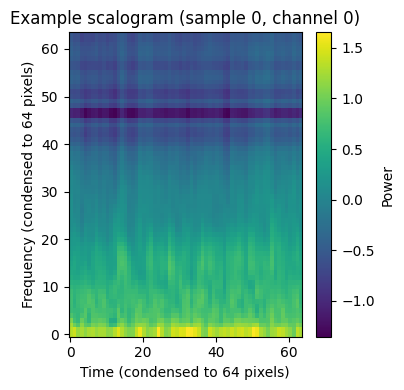

In [ ]:
# first sample of first image for scalograms
example_img = X_cnn[0, 0, :, :]

plt.figure(figsize=(4, 4))
plt.imshow(example_img, aspect="auto", origin="lower")
plt.colorbar(label="Power")
plt.title("Example scalogram (sample 0, channel 0)")
plt.xlabel("Time (condensed to 64 pixels)")
plt.ylabel("Frequency (condensed to 64 pixels)")
plt.tight_layout()
plt.show()


In [ ]:
# Never relly use this model again kinda bad
class SmallEEGCNN(nn.Module):
    def __init__(self, in_channels, img_size=64):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)  # 64 -> 32
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)  # 32 -> 16

        # feature map size after two poolings
        self.feature_map_size = img_size // 4  # 64 -> 16

        self.fc1 = nn.Linear(32 * self.feature_map_size * self.feature_map_size, 64)
        self.fc_out = nn.Linear(64, 1)  # for binary classification

    def forward(self, x):
        # x -> (batch, in_channels, H, W)
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc_out(x)
        return x


In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_cnn = np.array(X_cnn)
y_cnn = np.array(y_cnn).astype(np.float32)
groups = np.array(participant_ids_cnn)

N, in_channels, H, W = X_cnn.shape
print("X_cnn:", X_cnn.shape, "y_cnn:", y_cnn.shape, "groups:", groups.shape)


X_cnn: (200, 8, 64, 64) y_cnn: (200,) groups: (200,)


In [ ]:
logo = LeaveOneGroupOut()

num_epochs = 15
batch_size = 16
lr = 1e-3

all_acc = []
all_prec = []
all_rec = []


In [ ]:
all_acc = []
fold_precisions = [] # fold precisions
fold_recalls = [] # fold recalls
# used to compute not per fold metrics
all_folds_y_true = []
all_folds_y_pred = []

for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X_cnn, y_cnn, groups)):
    print(f"\nFold {fold_idx+1}: leaving out participant {groups[test_idx][0]}")

    X_train = X_cnn[train_idx] # (n_train, k, H, W)
    y_train = y_cnn[train_idx] # (n_train,)
    X_test = X_cnn[test_idx] # (n_test, k, H, W)
    y_test = y_cnn[test_idx] # (n_test,)

    # convert to tensors cause u need to use tensors
    X_train_t = torch.from_numpy(X_train).float()
    y_train_t = torch.from_numpy(y_train).unsqueeze(1)
    X_test_t = torch.from_numpy(X_test).float()
    y_test_t = torch.from_numpy(y_test).unsqueeze(1)

    train_ds = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    # model each fold
    model = SmallEEGCNN(in_channels=in_channels, img_size=H).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # actual training loop
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * xb.size(0)

        epoch_loss /= len(train_ds)

    # Actutually evaluating the model
    model.eval()
    with torch.no_grad():
        logits_test = model(X_test_t.to(device))
        probs_test = torch.sigmoid(logits_test).cpu().numpy().ravel()
        y_pred = (probs_test >= 0.5).astype(int)

    y_true = y_test.astype(int)

    # store accuracy for each fold
    acc = accuracy_score(y_true, y_pred)
    all_acc.append(acc)

    # accumulate all folds predictions for "global" metrics
    all_folds_y_true.extend(y_true)
    all_folds_y_pred.extend(y_pred)

    # computing precision recall for each fold (class 0 and class 1)
    prec, rec, f1, support = precision_recall_fscore_support(
        y_true,
        y_pred,
        labels=[0, 1],
        average=None,
        zero_division=0
    )
    fold_precisions.append(prec)
    fold_recalls.append(rec)



Fold 1: leaving out participant 0

Fold 2: leaving out participant 1

Fold 3: leaving out participant 2

Fold 4: leaving out participant 3

Fold 5: leaving out participant 4

Fold 6: leaving out participant 5

Fold 7: leaving out participant 6

Fold 8: leaving out participant 7

Fold 9: leaving out participant 8

Fold 10: leaving out participant 9

Fold 11: leaving out participant 10

Fold 12: leaving out participant 11

Fold 13: leaving out participant 12

Fold 14: leaving out participant 13

Fold 15: leaving out participant 14

Fold 16: leaving out participant 15

Fold 17: leaving out participant 16

Fold 18: leaving out participant 17

Fold 19: leaving out participant 18

Fold 20: leaving out participant 19


In [ ]:
all_acc = []
fold_precisions = [] # fold precisions
fold_recalls = [] # fold recalls
# used to compute not per fold metrics
all_folds_y_true = []
all_folds_y_pred = []

for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X_cnn, y_cnn, groups)):
    print(f"\nFold {fold_idx+1}: leaving out participant {groups[test_idx][0]}")

    X_train = X_cnn[train_idx] # (n_train, k, H, W)
    y_train = y_cnn[train_idx] # (n_train,)
    X_test = X_cnn[test_idx] # (n_test, k, H, W)
    y_test = y_cnn[test_idx] # (n_test,)

    # convert to tensors cause u need to use tensors
    X_train_t = torch.from_numpy(X_train).float()
    y_train_t = torch.from_numpy(y_train).unsqueeze(1)
    X_test_t = torch.from_numpy(X_test).float()
    y_test_t = torch.from_numpy(y_test).unsqueeze(1)

    train_ds = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    # model each fold
    model = SmallEEGCNN(in_channels=in_channels, img_size=H).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # actual training loop
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * xb.size(0)

        epoch_loss /= len(train_ds)

    # Actutually evaluating the model
    model.eval()
    with torch.no_grad():
        logits_test = model(X_test_t.to(device))
        probs_test = torch.sigmoid(logits_test).cpu().numpy().ravel()
        y_pred = (probs_test >= 0.5).astype(int)

    y_true = y_test.astype(int)

    # store accuracy for each fold
    acc = accuracy_score(y_true, y_pred)
    all_acc.append(acc)

    # accumulate all folds predictions for "global" metrics
    all_folds_y_true.extend(y_true)
    all_folds_y_pred.extend(y_pred)

    # computing precision recall for each fold (class 0 and class 1)
    prec, rec, f1, support = precision_recall_fscore_support(
        y_true,
        y_pred,
        labels=[0, 1],
        average=None,
        zero_division=0
    )
    fold_precisions.append(prec)
    fold_recalls.append(rec)



Fold 1: leaving out participant 0

Fold 2: leaving out participant 1

Fold 3: leaving out participant 2

Fold 4: leaving out participant 3

Fold 5: leaving out participant 4

Fold 6: leaving out participant 5

Fold 7: leaving out participant 6

Fold 8: leaving out participant 7

Fold 9: leaving out participant 8

Fold 10: leaving out participant 9

Fold 11: leaving out participant 10

Fold 12: leaving out participant 11

Fold 13: leaving out participant 12

Fold 14: leaving out participant 13

Fold 15: leaving out participant 14

Fold 16: leaving out participant 15

Fold 17: leaving out participant 16

Fold 18: leaving out participant 17

Fold 19: leaving out participant 18

Fold 20: leaving out participant 19


In [ ]:
fold_precisions = np.array(fold_precisions)
fold_recalls = np.array(fold_recalls)

mean_prec_class0, mean_prec_class1 = fold_precisions.mean(axis=0)
mean_recall_class0, mean_recall_class1 = fold_recalls.mean(axis=0)

all_folds_y_true = np.array(all_folds_y_true)
all_folds_y_pred = np.array(all_folds_y_pred)

# "global" metrics over all predictions
prec_global, rec_global, f1_global, support_global = precision_recall_fscore_support(
    all_folds_y_true,
    all_folds_y_pred,
    labels=[0, 1],
    average=None,
    zero_division=0
)

print("Metrics from aggregation across folds")
print("Accuracy across all folds:", np.mean(all_acc))

print("Mean precision for class 0 across folds:", mean_prec_class0)
print("Mean precision for class 1 across folds:", mean_prec_class1)

print("Mean recall for class 0 across folds:", mean_recall_class0)
print("Mean recall for class 1 across folds:", mean_recall_class1)

# Global metrics just be the ypred and ground truth for all preds combined together. It makes a bit more sense to use here bc test size just so low from LOGO.
print("------------------------------------")
print("Metrics computed on all folds combined (global)")

print("Global precision for class 0:", prec_global[0])
print("Global precision for class 1:", prec_global[1])

print("Global recall for class 0:", rec_global[0])
print("Global recall for class 1:", rec_global[1])


Metrics from aggregation across folds
Accuracy across all folds: 0.575
Mean precision for class 0 across folds: 0.3616666666666667
Mean precision for class 1 across folds: 0.5498412698412698
Mean recall for class 0 across folds: 0.2373809523809524
Mean recall for class 1 across folds: 0.7704960317460319
------------------------------------
Metrics computed on all folds combined (global)
Global precision for class 0: 0.5681818181818182
Global precision for class 1: 0.5769230769230769
Global recall for class 0: 0.27472527472527475
Global recall for class 1: 0.8256880733944955


In [ ]:
class ScalogramCNN(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        # 64x64 -> 32x32
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2)

        # 32x32 -> 16x16
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2)

        # 16x16 -> 8x8
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2)

        # Global average pool where it go from 8x8 -> 1x1 (works for any input size)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Small classifier head
        self.dropout = nn.Dropout(p=0.5)
        self.fc_out = nn.Linear(64, 1)   # turned into binary logits

    def forward(self, x):
        # x -> (batch, in_channels, H, W)
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        x = self.global_pool(x) # (batch, 64, 1, 1)
        x = x.view(x.size(0), -1) # (batch, 64)
        x = self.dropout(x)
        x = self.fc_out(x) # (batch, 1) logits
        return x


In [ ]:
all_acc = []
fold_precisions = [] # fold precisions
fold_recalls = [] # fold recalls
# used to compute not per fold metrics
all_folds_y_true = []
all_folds_y_pred = []

for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X_cnn, y_cnn, groups)):
    print(f"\nFold {fold_idx+1}: leaving out participant {groups[test_idx][0]}")

    X_train = X_cnn[train_idx] # (n_train, k, H, W)
    y_train = y_cnn[train_idx] # (n_train,)
    X_test = X_cnn[test_idx] # (n_test, k, H, W)
    y_test = y_cnn[test_idx] # (n_test,)

    # convert to tensors cause u need to use tensors
    X_train_t = torch.from_numpy(X_train).float()
    y_train_t = torch.from_numpy(y_train).unsqueeze(1)
    X_test_t = torch.from_numpy(X_test).float()
    y_test_t = torch.from_numpy(y_test).unsqueeze(1)

    train_ds = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    # model each fold
    model = ScalogramCNN(in_channels=in_channels).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    # actual training loop
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * xb.size(0)

        epoch_loss /= len(train_ds)

    # Actutually evaluating the model
    model.eval()
    with torch.no_grad():
        logits_test = model(X_test_t.to(device))
        probs_test = torch.sigmoid(logits_test).cpu().numpy().ravel()
        y_pred = (probs_test >= 0.5).astype(int)

    y_true = y_test.astype(int)

    # store accuracy for each fold
    acc = accuracy_score(y_true, y_pred)
    all_acc.append(acc)

    # accumulate all folds predictions for "global" metrics
    all_folds_y_true.extend(y_true)
    all_folds_y_pred.extend(y_pred)

    # computing precision recall for each fold (class 0 and class 1)
    prec, rec, f1, support = precision_recall_fscore_support(
        y_true,
        y_pred,
        labels=[0, 1],
        average=None,
        zero_division=0
    )
    fold_precisions.append(prec)
    fold_recalls.append(rec)



Fold 1: leaving out participant 0
  acc=0.600, prec0=0.500, prec1=0.625, rec0=0.250, rec1=0.833

Fold 2: leaving out participant 1
  acc=0.600, prec0=0.600, prec1=0.000, rec0=1.000, rec1=0.000

Fold 3: leaving out participant 2
  acc=1.000, prec0=0.000, prec1=1.000, rec0=0.000, rec1=1.000

Fold 4: leaving out participant 3
  acc=0.600, prec0=0.000, prec1=0.750, rec0=0.000, rec1=0.750

Fold 5: leaving out participant 4
  acc=0.700, prec0=0.333, prec1=0.857, rec0=0.500, rec1=0.750

Fold 6: leaving out participant 5
  acc=1.000, prec0=1.000, prec1=0.000, rec0=1.000, rec1=0.000

Fold 7: leaving out participant 6
  acc=0.200, prec0=0.000, prec1=0.200, rec0=0.000, rec1=1.000

Fold 8: leaving out participant 7
  acc=0.600, prec0=0.000, prec1=0.600, rec0=0.000, rec1=1.000

Fold 9: leaving out participant 8
  acc=0.400, prec0=0.000, prec1=0.400, rec0=0.000, rec1=1.000

Fold 10: leaving out participant 9
  acc=0.700, prec0=1.000, prec1=0.500, rec0=0.571, rec1=1.000

Fold 11: leaving out partici

In [ ]:
fold_precisions = np.array(fold_precisions)
fold_recalls = np.array(fold_recalls)

mean_prec_class0, mean_prec_class1 = fold_precisions.mean(axis=0)
mean_recall_class0, mean_recall_class1 = fold_recalls.mean(axis=0)

all_folds_y_true = np.array(all_folds_y_true)
all_folds_y_pred = np.array(all_folds_y_pred)

# "global" metrics over all predictions
prec_global, rec_global, f1_global, support_global = precision_recall_fscore_support(
    all_folds_y_true,
    all_folds_y_pred,
    labels=[0, 1],
    average=None,
    zero_division=0
)

print("Metrics from aggregation across folds")
print("Accuracy across all folds:", np.mean(all_acc))

print("Mean precision for class 0 across folds:", mean_prec_class0)
print("Mean precision for class 1 across folds:", mean_prec_class1)

print("Mean recall for class 0 across folds:", mean_recall_class0)
print("Mean recall for class 1 across folds:", mean_recall_class1)

# Global metrics just be the ypred and ground truth for all preds combined together. It makes a bit more sense to use here bc test size just so low from LOGO.
print("------------------------------------")
print("Metrics computed on all folds combined (global)")

print("Global precision for class 0:", prec_global[0])
print("Global precision for class 1:", prec_global[1])

print("Global recall for class 0:", rec_global[0])
print("Global recall for class 1:", rec_global[1])


Metrics from aggregation across folds
Accuracy across all folds: 0.62
Mean precision for class 0 across folds: 0.3102976190476191
Mean precision for class 1 across folds: 0.4660515873015873
Mean recall for class 0 across folds: 0.38095238095238093
Mean recall for class 1 across folds: 0.6331349206349207
------------------------------------
Metrics computed on all folds combined (global)
Global precision for class 0: 0.5974025974025974
Global precision for class 1: 0.6341463414634146
Global recall for class 0: 0.5054945054945055
Global recall for class 1: 0.7155963302752294
